In [1]:
import pandas as pd
import time
DATA_PATH = "../data/dairy_cows.csv"  # or wherever your data is located

df = pd.read_csv(DATA_PATH)
df.head()

,ID,Species,Animal_Class,WQ_Principles,WQ_Criteria,Welfare_Hazards_Animal,Welfare_Hazards_Consequences,Welfare_Hazards_Affective_States,Welfare_Hazards_Impact,Ease_of_Hazard_Mitigation,Welfare_Indicator,Indicator_Type,Indicator_Dimensions,Indicator_Ease,Indicator_Resources,Hazards_Source_1,Hazards_Source_2,Global_Usage,Norway_Usage
0,1,Dairy cows,Tie stalls,Good Health,Absence of disease,Pasture access,Gastro-enteric disorders,Discomfort,High,Moderate,Abdominal discomfort,Welfare outcome,Health/physical/production,Moderate,Low,7.0,NaN,F,Y
1,1,Dairy cows,Cubicles,Good Health,Absence of disease,Pasture access,Gastro-enteric disorders,Discomfort,High,Moderate,Abdominal discomfort,Welfare outcome,Health/physical/production,Moderate,Low,7.0,NaN,F,Y
2,2,Dairy cows,Tie stalls,Appropiate behaviour,Expression of social behaviours,Continuous housing for long periods,General disruption of behaviour,Di(stress),Low,Difficult,Agonistic behaviour,Welfare outcome,Behavioural,Moderate,Low,7.0,NaN,"F, R",Y
3,2,Dairy cows,Cubicles,Appropiate behaviour,Expression of social behaviours,Continuous housing for long periods,General disruption of behaviour,Di(stress),Low,Difficult,Agonistic behaviour,Welfare outcome,Behavioural,Moderate,Low,7.0,NaN,"F, R",Y
4,3,Dairy cows,Tie stalls,Appropiate behaviour,Expression of other behaviours,Insufficient space,Restriction of movement,Discomfort,High,Moderate,Agonistic interactions,Welfare outcome,Behavioural,Moderate,Medium,NaN,13a,R,N (research only)



## Plots of % combination space explained

For our analysis we focus on:
 - Welfare_Indicator (the unique indicator)
 - Welfare_Hazards_Animal (for hazards)
 - Welfare_Hazards_Consequences (for consequences)
 - Species and Animal_Class (to group the data)


In [3]:


# Group data by Species and Animal_Class
groups = df.groupby(['Species', 'Animal_Class'])

# Prepare dictionaries to store cumulative percentages for each group and metric.
# Each dictionary: keys = (Species, Animal_Class); values = DataFrame with columns:
#   'num_indicators', 'cum_pct_consequences', 'cum_pct_hazards', 'cum_pct_combined'
results = {}



In [4]:
for (species, animal_class), group in groups:
    print(species)
    print(animal_class)

Dairy cows
Cubicles
Dairy cows
Tie stalls


For each indicator, compute:
 - unique consequences it covers in the group
 - unique hazards it covers in the group
 - unique pairs (hazard, consequence) it covers

In [5]:
# Loop over each group
for (species, animal_class), group in groups:
    # Get unique indicators in this group (keeping their order, you may sort if needed)
    indicators = group['Welfare_Indicator'].unique()
    

    indicator_data = []
    for ind in indicators:
        subset = group[group['Welfare_Indicator'] == ind]
        cons = set(subset['Welfare_Hazards_Consequences'].unique())
        haz = set(subset['Welfare_Hazards_Animal'].unique())
        combined = {(h, c) for h in haz for c in cons}
        indicator_data.append({
            'indicator': ind,
            'consequences': cons,
            'hazards': haz,
            'combined': combined,
            'coverage_count': len(cons) + len(haz)  # simple sum of counts
        })
    # Convert to DataFrame
    ind_df = pd.DataFrame(indicator_data)
    
    # Sort indicators by their coverage_count (or other metric if desired) in descending order
    ind_df = ind_df.sort_values(by='coverage_count', ascending=False).reset_index(drop=True)
    
    # Compute total unique consequences, hazards, and combined in the group
    total_consequences = set(group['Welfare_Hazards_Consequences'].unique())
    total_hazards = set(group['Welfare_Hazards_Animal'].unique())
    total_combined = {(h, c) for h in total_hazards for c in total_consequences}
    
    n_total_cons = len(total_consequences)
    n_total_haz = len(total_hazards)
    n_total_combined = len(total_combined)
    
    # Initialize lists to store cumulative values
    cum_cons = []
    cum_haz = []
    cum_comb = []
    num_indicators = []
    
    covered_cons = set()
    covered_haz = set()
    covered_comb = set()
    
    # Iterate over indicators in sorted order and update cumulative counts
    for i, row in ind_df.iterrows():
        covered_cons.update(row['consequences'])
        covered_haz.update(row['hazards'])
        covered_comb.update(row['combined'])
        
        num_indicators.append(i + 1)
        cum_cons.append(len(covered_cons) / n_total_cons * 100)
        cum_haz.append(len(covered_haz) / n_total_haz * 100)
        cum_comb.append(len(covered_comb) / n_total_combined * 100)
    
    # Store results in a DataFrame for this group
    results[(species, animal_class)] = pd.DataFrame({
        'num_indicators': num_indicators,
        'cum_pct_consequences': cum_cons,
        'cum_pct_hazards': cum_haz,
        'cum_pct_combined': cum_comb
    })



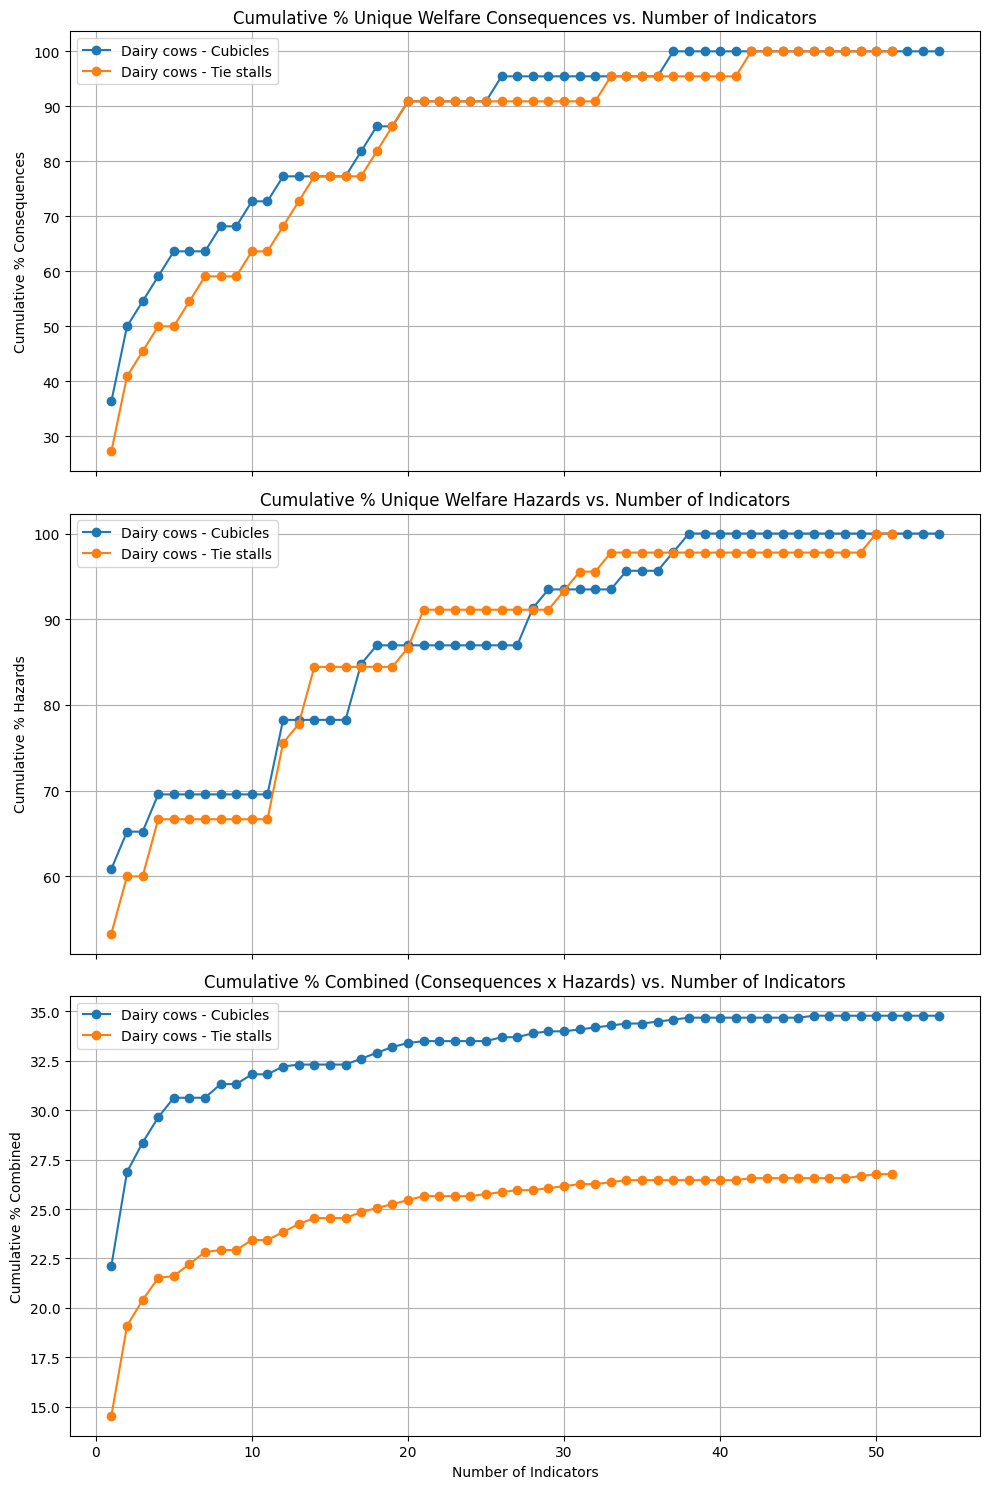

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
# ----------------------------
# Plotting the Results
# ----------------------------

# We'll create one figure with three subplots for each metric.
# And we will overlay the curves for each (Species, Animal_Class) group.

fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

# Define a color palette
colors = sns.color_palette("tab10", len(results))

for idx, ((species, animal_class), df_res) in enumerate(results.items()):
    label = f"{species} - {animal_class}"
    # Plot cumulative % unique welfare consequences
    axes[0].plot(df_res['num_indicators'], df_res['cum_pct_consequences'], marker='o', label=label, color=colors[idx])
    # Plot cumulative % unique welfare hazards
    axes[1].plot(df_res['num_indicators'], df_res['cum_pct_hazards'], marker='o', label=label, color=colors[idx])
    # Plot cumulative % combined coverage
    axes[2].plot(df_res['num_indicators'], df_res['cum_pct_combined'], marker='o', label=label, color=colors[idx])

# Set titles and labels
axes[0].set_title("Cumulative % Unique Welfare Consequences vs. Number of Indicators")
axes[0].set_ylabel("Cumulative % Consequences")
axes[1].set_title("Cumulative % Unique Welfare Hazards vs. Number of Indicators")
axes[1].set_ylabel("Cumulative % Hazards")
axes[2].set_title("Cumulative % Combined (Consequences x Hazards) vs. Number of Indicators")
axes[2].set_ylabel("Cumulative % Combined")
axes[2].set_xlabel("Number of Indicators")

for ax in axes:
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

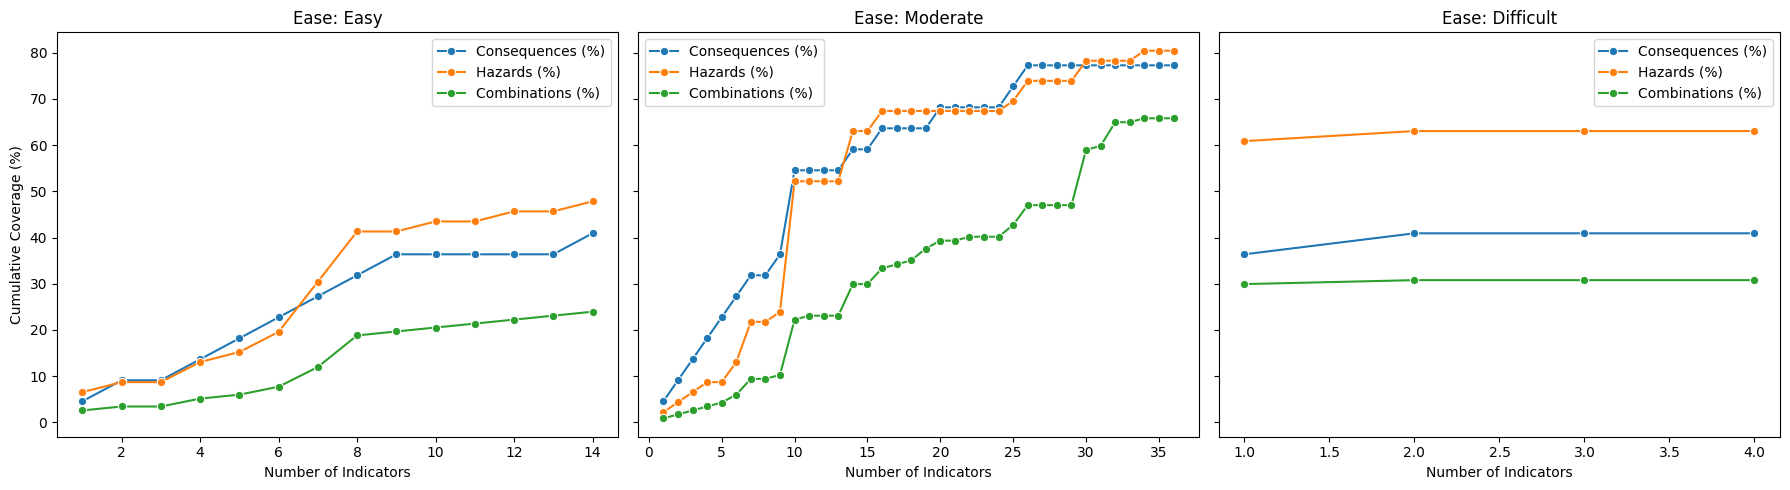

In [13]:
import numpy as np
ease_categories = ['Easy', 'Moderate', 'Difficult']

# Function to compute cumulative coverage
def compute_coverage(df_filtered):
    indicators = df_filtered['Welfare_Indicator'].unique()
    cumulative_consequences = []
    cumulative_hazards = []
    cumulative_combinations = []

    covered_consequences = set()
    covered_hazards = set()
    covered_combinations = set()

    for ind in indicators:
        subset = df_filtered[df_filtered['Welfare_Indicator'] == ind]
        covered_consequences.update(subset['Welfare_Hazards_Consequences'].unique())
        covered_hazards.update(subset['Welfare_Hazards_Animal'].unique())
        covered_combinations.update(set(zip(subset['Welfare_Hazards_Consequences'], subset['Welfare_Hazards_Animal'])))

        cumulative_consequences.append(len(covered_consequences))
        cumulative_hazards.append(len(covered_hazards))
        cumulative_combinations.append(len(covered_combinations))

    total_consequences = df['Welfare_Hazards_Consequences'].nunique()
    total_hazards = df['Welfare_Hazards_Animal'].nunique()
    total_combinations = df[['Welfare_Hazards_Consequences', 'Welfare_Hazards_Animal']].drop_duplicates().shape[0]

    return pd.DataFrame({
        'Indicators': range(1, len(indicators)+1),
        'Consequences (%)': np.array(cumulative_consequences) / total_consequences * 100,
        'Hazards (%)': np.array(cumulative_hazards) / total_hazards * 100,
        'Combinations (%)': np.array(cumulative_combinations) / total_combinations * 100
    })

# Plot cumulative coverage by ease category
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for idx, ease in enumerate(ease_categories):
    df_filtered = df[df['Indicator_Ease'] == ease]
    coverage_df = compute_coverage(df_filtered)

    sns.lineplot(data=coverage_df, x='Indicators', y='Consequences (%)', marker='o', ax=axes[idx], label='Consequences (%)')
    sns.lineplot(data=coverage_df, x='Indicators', y='Hazards (%)', marker='o', ax=axes[idx], label='Hazards (%)')
    sns.lineplot(data=coverage_df, x='Indicators', y='Combinations (%)', marker='o', ax=axes[idx], label='Combinations (%)')

    axes[idx].set_title(f'Ease: {ease}')
    axes[idx].set_xlabel('Number of Indicators')
    axes[idx].set_ylabel('Cumulative Coverage (%)')
    axes[idx].legend()

plt.tight_layout()
plt.show()

In [20]:
df = pd.read_csv(DATA_PATH)
df.head()

,ID,Species,Animal_Class,WQ_Principles,WQ_Criteria,Welfare_Hazards_Animal,Welfare_Hazards_Consequences,Welfare_Hazards_Affective_States,Welfare_Hazards_Impact,Ease_of_Hazard_Mitigation,Welfare_Indicator,Indicator_Type,Indicator_Dimensions,Indicator_Ease,Indicator_Resources,Hazards_Source_1,Hazards_Source_2,Global_Usage,Norway_Usage
0,1,Dairy cows,Tie stalls,Good Health,Absence of disease,Pasture access,Gastro-enteric disorders,Discomfort,High,Moderate,Abdominal discomfort,Welfare outcome,Health/physical/production,Moderate,Low,7.0,NaN,F,Y
1,1,Dairy cows,Cubicles,Good Health,Absence of disease,Pasture access,Gastro-enteric disorders,Discomfort,High,Moderate,Abdominal discomfort,Welfare outcome,Health/physical/production,Moderate,Low,7.0,NaN,F,Y
2,2,Dairy cows,Tie stalls,Appropiate behaviour,Expression of social behaviours,Continuous housing for long periods,General disruption of behaviour,Di(stress),Low,Difficult,Agonistic behaviour,Welfare outcome,Behavioural,Moderate,Low,7.0,NaN,"F, R",Y
3,2,Dairy cows,Cubicles,Appropiate behaviour,Expression of social behaviours,Continuous housing for long periods,General disruption of behaviour,Di(stress),Low,Difficult,Agonistic behaviour,Welfare outcome,Behavioural,Moderate,Low,7.0,NaN,"F, R",Y
4,3,Dairy cows,Tie stalls,Appropiate behaviour,Expression of other behaviours,Insufficient space,Restriction of movement,Discomfort,High,Moderate,Agonistic interactions,Welfare outcome,Behavioural,Moderate,Medium,NaN,13a,R,N (research only)


### **1. Data Preparation**

- Create numeric representations for relevant variables to be used in optimization:

| Column                     | Numeric Mapping               |
|----------------------------|-------------------------------|
| **Ease_of_Indicator**      | Easy=1, Moderate=2, Difficult=3 |
| **Welfare_Hazards_Impact** | Low=1, High=2                 |
| **Ease_of_Hazard_Mitigation** | Easy=1, Moderate=2, Difficult=3 |


In [30]:
mapping_ease = {'Easy': 1, 'Moderate': 2, 'Difficult': 3}
mapping_impact = {'Low': 1, 'High': 2}

df['Ease_Num'] = df['Indicator_Ease'].map(mapping_ease)
df['Impact_Num'] = df['Welfare_Hazards_Impact'].map(mapping_impact)
df['Mitigation_Ease_Num'] = df['Ease_of_Hazard_Mitigation'].map(mapping_ease)
df['Indicator_Ease_Num'] = df['Indicator_Ease'].map(mapping_ease)

df.head()


,ID,Species,Animal_Class,WQ_Principles,WQ_Criteria,Welfare_Hazards_Animal,Welfare_Hazards_Consequences,Welfare_Hazards_Affective_States,Welfare_Hazards_Impact,Ease_of_Hazard_Mitigation,...,Hazards_Source_2,Global_Usage,Norway_Usage,Ease_Num,Impact_Num,Mitigation_Ease_Num,Risk_Coverage,Consequence_Coverage,Coverage_Score,Indicator_Ease_Num
0,1,Dairy cows,Tie stalls,Good Health,Absence of disease,Pasture access,Gastro-enteric disorders,Discomfort,High,Moderate,...,NaN,F,Y,2,2,2,1,1,1.0,2
1,1,Dairy cows,Cubicles,Good Health,Absence of disease,Pasture access,Gastro-enteric disorders,Discomfort,High,Moderate,...,NaN,F,Y,2,2,2,1,1,1.0,2
2,2,Dairy cows,Tie stalls,Appropiate behaviour,Expression of social behaviours,Continuous housing for long periods,General disruption of behaviour,Di(stress),Low,Difficult,...,NaN,"F, R",Y,2,1,3,1,1,1.0,2
3,2,Dairy cows,Cubicles,Appropiate behaviour,Expression of social behaviours,Continuous housing for long periods,General disruption of behaviour,Di(stress),Low,Difficult,...,NaN,"F, R",Y,2,1,3,1,1,1.0,2
4,3,Dairy cows,Tie stalls,Appropiate behaviour,Expression of other behaviours,Insufficient space,Restriction of movement,Discomfort,High,Moderate,...,13a,R,N (research only),2,2,2,1,1,1.0,2


### **2. Calculate Coverage**

- For each indicator, we calculate:

  - **Risk coverage**: Number of unique welfare hazards it covers.
  - **Consequence coverage**: Number of unique welfare consequences it covers.

In [31]:
# Calculate risk and consequence coverage
indicator_risk_coverage = df.groupby('Welfare_Indicator')['Welfare_Hazards_Animal'].nunique()
indicator_consequence_coverage = df.groupby('Welfare_Indicator')['Welfare_Hazards_Consequences'].nunique()

# Add these coverage columns back to DataFrame
df['Risk_Coverage'] = df['Welfare_Indicator'].map(indicator_risk_coverage)
df['Consequence_Coverage'] = df['Welfare_Indicator'].map(indicator_consequence_coverage)

df.head()


,ID,Species,Animal_Class,WQ_Principles,WQ_Criteria,Welfare_Hazards_Animal,Welfare_Hazards_Consequences,Welfare_Hazards_Affective_States,Welfare_Hazards_Impact,Ease_of_Hazard_Mitigation,...,Hazards_Source_2,Global_Usage,Norway_Usage,Ease_Num,Impact_Num,Mitigation_Ease_Num,Risk_Coverage,Consequence_Coverage,Coverage_Score,Indicator_Ease_Num
0,1,Dairy cows,Tie stalls,Good Health,Absence of disease,Pasture access,Gastro-enteric disorders,Discomfort,High,Moderate,...,NaN,F,Y,2,2,2,1,1,1.0,2
1,1,Dairy cows,Cubicles,Good Health,Absence of disease,Pasture access,Gastro-enteric disorders,Discomfort,High,Moderate,...,NaN,F,Y,2,2,2,1,1,1.0,2
2,2,Dairy cows,Tie stalls,Appropiate behaviour,Expression of social behaviours,Continuous housing for long periods,General disruption of behaviour,Di(stress),Low,Difficult,...,NaN,"F, R",Y,2,1,3,1,1,1.0,2
3,2,Dairy cows,Cubicles,Appropiate behaviour,Expression of social behaviours,Continuous housing for long periods,General disruption of behaviour,Di(stress),Low,Difficult,...,NaN,"F, R",Y,2,1,3,1,1,1.0,2
4,3,Dairy cows,Tie stalls,Appropiate behaviour,Expression of other behaviours,Insufficient space,Restriction of movement,Discomfort,High,Moderate,...,13a,R,N (research only),2,2,2,1,1,1.0,2


## **3: Define Individual Objective Components**

We now define clearly each part of the objective for each indicator:

- **Coverage Score** (`coverage_score`): Weighted sum of risk and consequence coverage.
- **Easiness Score** (`easiness_score`): Higher if indicator is easy to measure.
- **Impact Score** (`impact_score`): Directly proportional to welfare hazard impact.
- **Mitigation Score** (`mitigation_score`): Prefers indicators associated with hazards easy to mitigate.

In [34]:
# Objective component weights (example values, adjustable)
alpha = 0.5
beta = 0.5
w_cover = 1.0
w_ease = 1.0
w_impact = 1.0
w_miti = 1.0

# Calculate scores
df['Coverage_Score'] = alpha * df['Risk_Coverage'] + beta * df['Consequence_Coverage']
df['Easiness_Score'] = 4 - df['Indicator_Ease_Num']  # Easy=3, Moderate=2, Difficult=1
df['Impact_Score'] = df['Impact_Num']
df['Mitigation_Score'] = 4 - df['Mitigation_Ease_Num']  # Easy=3, Moderate=2, Difficult=1

df.head()


,ID,Species,Animal_Class,WQ_Principles,WQ_Criteria,Welfare_Hazards_Animal,Welfare_Hazards_Consequences,Welfare_Hazards_Affective_States,Welfare_Hazards_Impact,Ease_of_Hazard_Mitigation,...,Ease_Num,Impact_Num,Mitigation_Ease_Num,Risk_Coverage,Consequence_Coverage,Coverage_Score,Indicator_Ease_Num,Easiness_Score,Impact_Score,Mitigation_Score
0,1,Dairy cows,Tie stalls,Good Health,Absence of disease,Pasture access,Gastro-enteric disorders,Discomfort,High,Moderate,...,2,2,2,1,1,1.0,2,2,2,2
1,1,Dairy cows,Cubicles,Good Health,Absence of disease,Pasture access,Gastro-enteric disorders,Discomfort,High,Moderate,...,2,2,2,1,1,1.0,2,2,2,2
2,2,Dairy cows,Tie stalls,Appropiate behaviour,Expression of social behaviours,Continuous housing for long periods,General disruption of behaviour,Di(stress),Low,Difficult,...,2,1,3,1,1,1.0,2,2,1,1
3,2,Dairy cows,Cubicles,Appropiate behaviour,Expression of social behaviours,Continuous housing for long periods,General disruption of behaviour,Di(stress),Low,Difficult,...,2,1,3,1,1,1.0,2,2,1,1
4,3,Dairy cows,Tie stalls,Appropiate behaviour,Expression of other behaviours,Insufficient space,Restriction of movement,Discomfort,High,Moderate,...,2,2,2,1,1,1.0,2,2,2,2


## **4 Define the Combined Objective**

Combine the previous scores into one unified objective function per indicator:

$$
objective_i = w_{cover}(\alpha \times RiskCoverage_i + \beta \times ConsequenceCoverage_i) + w_{ease}(EasinessScore_i) + w_{impact}(ImpactScore_i) + w_{miti}(MitigationScore_i)
$$

In [36]:
# Compute total combined objective score
df['Objective_Score'] = (
    w_cover * df['Coverage_Score'] +
    w_ease * df['Easiness_Score'] +
    w_impact * df['Impact_Score'] +
    w_miti * df['Mitigation_Score']
)

# Remove duplicate indicators to get unique indicators
unique_indicators = df[['Welfare_Indicator', 'Objective_Score']].drop_duplicates().reset_index(drop=True)

unique_indicators.head()


,Welfare_Indicator,Objective_Score
0,Abdominal discomfort,7.0
1,Agonistic behaviour,5.0
2,Agonistic interactions,7.0
3,Allo-grooming,5.0
4,Altered resting posture,6.0


## **5: Set up OR-Tools Optimization**

Use OR-Tools to select the optimal subset of indicators maximizing the total objective score, subject to the constraint that exactly `k` indicators are selected.


In [37]:
from ortools.linear_solver import pywraplp

# Number of indicators to select
k = 5  # Example: Select exactly 5 indicators

# Setup solver
solver = pywraplp.Solver.CreateSolver('SCIP')

# Decision variables: binary selection of indicators
x = {}
for i, row in unique_indicators.iterrows():
    x[i] = solver.BoolVar(f"x_{i}")

# Constraint: select exactly k indicators
solver.Add(solver.Sum([x[i] for i in x]) == k)

# Objective: maximize total score
objective = solver.Sum([x[i] * row['Objective_Score'] for i, row in unique_indicators.iterrows()])
solver.Maximize(objective)

# Solve the model
status = solver.Solve()

# Check solution status
if status == pywraplp.Solver.OPTIMAL:
    print('Optimal solution found!')
    selected_indicators = [unique_indicators.loc[i, 'Welfare_Indicator'] for i in x if x[i].solution_value() == 1]
    print("Selected Indicators:", selected_indicators)
    print("Total Objective Score:", solver.Objective().Value())
else:
    print('The solver did not find an optimal solution.')


Optimal solution found!
Selected Indicators: ['Cow Pain Scale (attention towards surroundings, head position, ear position, facial expression, response to approach, back position, lameness)', 'Physiological stress indicators', 'Physiological stress indicators', 'Physiological stress indicators', 'Physiological stress indicators']
Total Objective Score: 107.0


In [38]:
import numpy as np

# Baseline random selection
np.random.seed(42)
baseline_selection = unique_indicators.sample(k)
baseline_score = baseline_selection['Objective_Score'].sum()

print("Baseline Indicators:", baseline_selection['Welfare_Indicator'].tolist())
print("Baseline Objective Score:", baseline_score)

Baseline Indicators: ['Impaired social behaviour', 'Disease', 'Metabolic disorders', 'Step activity', 'Abdominal discomfort']
Baseline Objective Score: 32.0


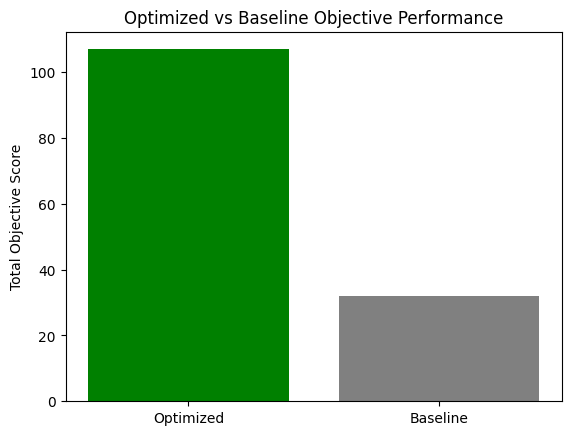

In [39]:
import matplotlib.pyplot as plt

# Scores
optimized_score = solver.Objective().Value()

# Plot comparison
plt.bar(['Optimized', 'Baseline'], [optimized_score, baseline_score], color=['green', 'grey'])
plt.ylabel('Total Objective Score')
plt.title('Optimized vs Baseline Objective Performance')
plt.show()

In [40]:
from ortools.linear_solver import pywraplp

def optimize_indicators(df, num_indicators, weights):
    alpha, beta, w_cover, w_ease, w_impact, w_miti = weights
    
    # Calculate Objective_Score again if weights changed
    df['Objective_Score'] = (
        w_cover * (alpha * df['Risk_Coverage'] + beta * df['Consequence_Coverage']) +
        w_ease * (4 - df['Indicator_Ease_Num']) +
        w_impact * df['Impact_Num'] +
        w_miti * (4 - df['Mitigation_Ease_Num'])
    )

    # Unique indicators
    indicators_df = df[['Welfare_Indicator', 'Objective_Score']].drop_duplicates().reset_index(drop=True)

    # OR-Tools solver
    solver = pywraplp.Solver.CreateSolver('SCIP')

    x = {}
    for i in indicators_df.index:
        x[i] = solver.BoolVar(f"x_{i}")

    solver.Add(solver.Sum([x[i] for i in x]) == num_indicators)

    solver.Maximize(solver.Sum([x[i] * indicators_df.loc[i, 'Objective_Score'] for i in x]))

    status = solver.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        selected = [indicators_df.loc[i, 'Welfare_Indicator'] for i in x if x[i].solution_value() == 1]
        optimal_value = solver.Objective().Value()
    else:
        selected, optimal_value = [], None

    return optimal_value, selected


In [51]:
import pandas as pd

# Define scenarios
num_indicators_list = [2, 4, 6, 8, 10, 12, 14, 16, 18]  # Varying number of indicators
weights_scenarios = [
    (0.5, 0.5, 1, 1, 1, 1),   # Equal emphasis (default)
    (0.7, 0.3, 1, 1, 1, 1),   # Emphasis more on risks coverage
    (0.3, 0.7, 1, 1, 1, 1),   # Emphasis more on consequences coverage
    (0.5, 0.5, 1, 2, 1, 1),   # Emphasis more on easiness of indicator
    (0.5, 0.5, 1, 1, 2, 1),   # Emphasis more on impact
]

# DataFrame to store results
results = []

for weights in weights_scenarios:
    for num_indicators in num_indicators_list:
        optimal_val, selected_inds = optimize_indicators(df, num_indicators, weights)
        
        results.append({
            'Num_Indicators': num_indicators,
            'Weights': weights,
            'Optimal_Value': optimal_val,
            'Selected_Indicators': selected_inds
        })

results_df = pd.DataFrame(results)

results_df.head()


,Num_Indicators,Weights,Optimal_Value,Selected_Indicators
0,2,"(0.5, 0.5, 1, 1, 1, 1)",47.0,"[Physiological stress indicators, Physiologica..."
1,4,"(0.5, 0.5, 1, 1, 1, 1)",90.0,"[Physiological stress indicators, Physiologica..."
2,6,"(0.5, 0.5, 1, 1, 1, 1)",123.0,[Cow Pain Scale (attention towards surrounding...
3,8,"(0.5, 0.5, 1, 1, 1, 1)",152.0,[Cow Pain Scale (attention towards surrounding...
4,10,"(0.5, 0.5, 1, 1, 1, 1)",179.0,[Cow Pain Scale (attention towards surrounding...


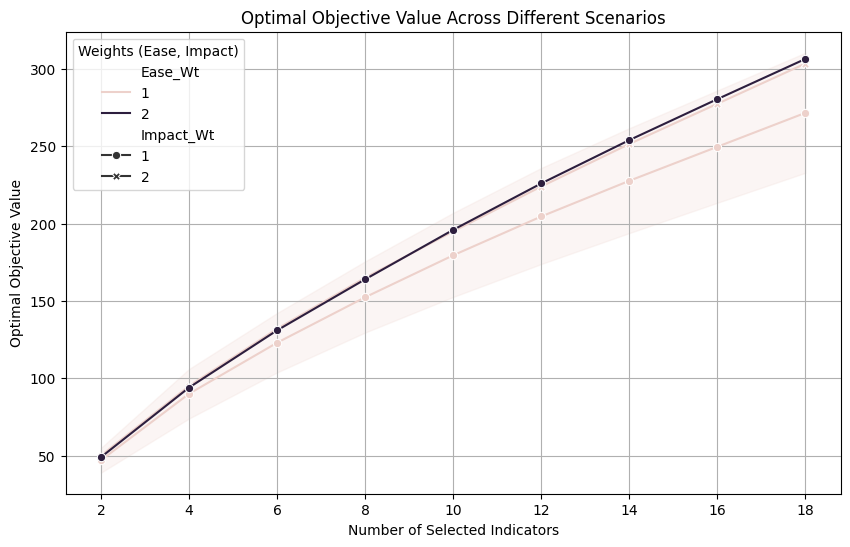

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Expand weights tuple for readability
results_df['Risk_Wt'] = results_df['Weights'].apply(lambda x: x[0])
results_df['Cons_Wt'] = results_df['Weights'].apply(lambda x: x[1])
results_df['Ease_Wt'] = results_df['Weights'].apply(lambda x: x[3])
results_df['Impact_Wt'] = results_df['Weights'].apply(lambda x: x[4])

# Example visualization for varying number of indicators
plt.figure(figsize=(10,6))
sns.lineplot(
    data=results_df, 
    x='Num_Indicators', 
    y='Optimal_Value', 
    hue='Ease_Wt', 
    style='Impact_Wt',
    markers=True, dashes=False
)
plt.title("Optimal Objective Value Across Different Scenarios")
plt.xlabel("Number of Selected Indicators")
plt.ylabel("Optimal Objective Value")
plt.legend(title='Weights (Ease, Impact)')
plt.grid(True)
plt.show()


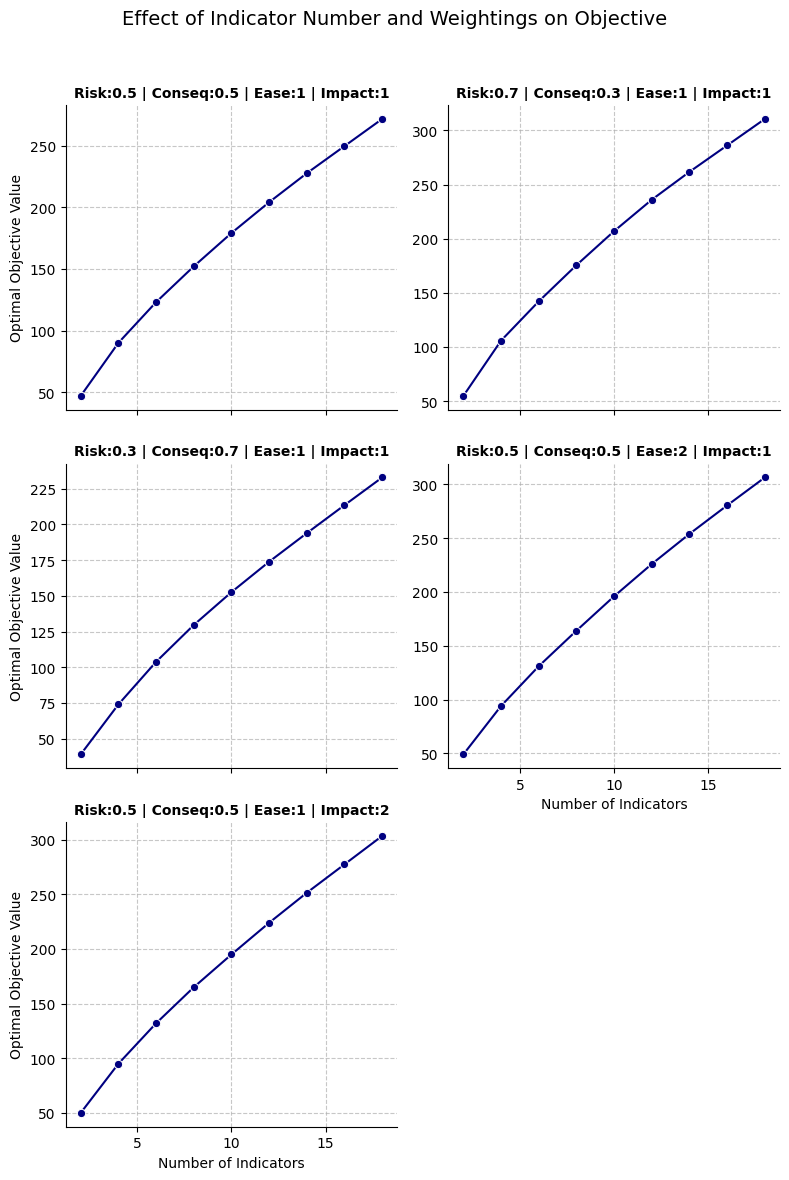

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming results_df from previous step
results_df_expanded = results_df.copy()

# Expand weights for clearer labels
results_df_expanded['Scenario'] = results_df_expanded['Weights'].apply(
    lambda w: f'Risk:{w[0]} | Conseq:{w[1]} | Ease:{w[3]} | Impact:{w[4]}'
)

# Plot each scenario separately with clear labels
g = sns.FacetGrid(results_df_expanded, col="Scenario", col_wrap=2, height=4, sharey=False)

g.map_dataframe(
    sns.lineplot, x='Num_Indicators', y='Optimal_Value', marker='o', color='navy'
)

g.set_axis_labels("Number of Indicators", "Optimal Objective Value")
g.set_titles("{col_name}", size=10, fontweight='bold')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Effect of Indicator Number and Weightings on Objective', fontsize=14)

for ax in g.axes.flatten():
    ax.grid(True, linestyle='--', alpha=0.7)

plt.show()


In [55]:
import pandas as pd
import numpy as np
from ortools.linear_solver import pywraplp
from io import StringIO

# Load and preprocess your data
def load_data():
    df = pd.read_csv(DATA_PATH)
    return df

# Compute coverage for risks and consequences
def compute_coverage(df):
    coverage_dict = {}
    indicators = df['Welfare_Indicator'].unique()
    for ind in indicators:
        sub_df = df[df['Welfare_Indicator'] == ind]
        risks = sub_df['Welfare_Hazards_Animal'].nunique()
        consequences = sub_df['Welfare_Hazards_Consequences'].nunique()
        coverage_dict[ind] = {'risks': risks, 'consequences': consequences}
    return coverage_dict

# Map textual fields to numeric
def preprocess_numeric(df):
    ease_mapping = {'Easy': 1, 'Moderate': 2, 'Difficult': 3}
    impact_mapping = {'High': 2, 'Low': 1}
    df['Ease_Num'] = df['Indicator_Ease'].map(ease_mapping)
    df['Impact_Num'] = df['Welfare_Hazards_Impact'].map(impact_mapping)
    df['Mitigation_Ease_Num'] = df['Ease_of_Hazard_Mitigation'].map(ease_mapping)
    return df

# OR-Tools Optimization Function
def run_optimization(params):
    df = load_data()
    df = preprocess_numeric(df)
    coverage = compute_coverage(df)
    indicators = list(coverage.keys())

    solver = pywraplp.Solver.CreateSolver('SCIP')

    # Decision variables
    x = {ind: solver.BoolVar(ind) for ind in indicators}

    # Objective function parameters
    alpha = params.get('w_risk', 1.0)
    beta = params.get('w_consequence', 1.0)
    w_cover = params.get('w_cover', 1.0)
    w_ease = params.get('w_ease', 1.0)
    w_impact = params.get('w_impact', 1.0)
    w_mitigation = params.get('w_mitigation', 1.0)

    # Construct Objective Function
    objective = solver.Objective()

    for ind in indicators:
        cov = alpha * coverage[ind]['risks'] + beta * coverage[ind]['consequences']
        ease = -(df[df['Welfare_Indicator'] == ind]['Ease_Num'].iloc[0])
        impact = df[df['Welfare_Indicator'] == ind]['Impact_Num'].iloc[0]
        mitigation = -(df[df['Welfare_Indicator'] == ind]['Mitigation_Ease_Num'].iloc[0])

        total_score = (w_cover * cov + w_ease * ease + w_impact * impact + w_mitigation * mitigation)
        objective.SetCoefficient(x[ind], total_score)

    objective.SetMaximization()

    # Constraint (example budget constraint)
    budget = params.get('budget', 10)
    solver.Add(sum(x[ind] for ind in indicators) <= budget)

    # Solve
    status = solver.Solve()

    selected_indicators = [ind for ind in indicators if x[ind].solution_value() > 0.5]
    optimal_value = solver.Objective().Value()

    return {'selected_indicators': selected_indicators, 'optimal_value': optimal_value}

# Example usage:
params = {'w_cover': 1.0, 'w_risk': 1.0, 'w_consequence': 1.0,
          'w_ease': 1.0, 'w_impact': 1.0, 'w_mitigation': 1.0,
          'budget': 5}
result = run_optimization(params)
print('Selected Indicators:', result['selected_indicators'])
print('Optimal Objective Value:', result['optimal_value'])

Selected Indicators: ['Cow Pain Scale (attention towards surroundings, head position, ear position, facial expression, response to approach, back position, lameness)', 'Gait assessment', 'Injuries', 'Physiological stress indicators', 'Time budgets (disruption of behaviour)']
Optimal Objective Value: 77.0


In [56]:
import numpy as np
import pandas as pd
from ortools.linear_solver import pywraplp

# Example: Define base parameters clearly
base_parameters = {
    'w_cover': 1.0,
    'w_risk': 1.0,
    'w_consequence': 1.0,
    'w_ease': 1.0,
    'w_impact': 1.0,
    'w_mitigation': 1.0,
    'budget': 1000,
}

# Run optimization function under base scenario
optimal_base = run_optimization(base_parameters)
base_optimal_value = optimal_base['optimal_value']

print(f"Base Optimal Value: {base_optimal_value}")


Base Optimal Value: 141.0


In [57]:
sensitivity_results = []

parameter_variations = [-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6]

for param in ['w_cover', 'w_ease', 'w_impact', 'budget']:
    for variation in parameter_variations:
        params = base_parameters.copy()
        params[param] *= (1 + variation)

        optimal_solution = run_optimization(params)
        sensitivity_results.append({
            'Parameter': param,
            'Variation (%)': variation * 100,
            'Optimal Value': optimal_solution['optimal_value']
        })

sensitivity_df = pd.DataFrame(sensitivity_results)


## Sensitivity analysis

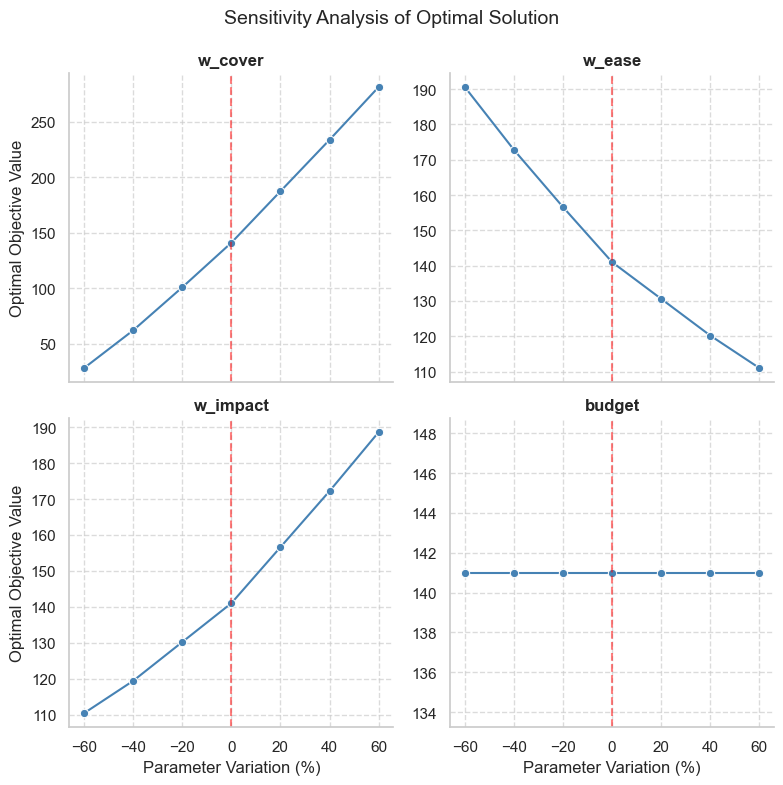

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

g = sns.FacetGrid(sensitivity_df, col='Parameter', col_wrap=2, height=4, sharey=False)
g.map_dataframe(sns.lineplot, 'Variation (%)', 'Optimal Value', marker='o', color='steelblue')
g.set_axis_labels('Parameter Variation (%)', 'Optimal Objective Value')
g.set_titles('{col_name}', fontsize=12, fontweight='bold')

for ax in g.axes.flatten():
    ax.axvline(0, linestyle='--', color='red', alpha=0.5)
    ax.grid(True, linestyle='--', alpha=0.7)

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Sensitivity Analysis of Optimal Solution', fontsize=14)

plt.show()


## Stability Analysis

In [59]:
stability_results = []

for param in ['w_cover', 'w_ease', 'w_impact', 'budget']:
    for variation in [-0.5, 0, 0.5]:
        params = base_parameters.copy()
        params[param] *= (1 + variation)

        optimal_solution = run_optimization(params)
        stability_results.append({
            'Parameter': param,
            'Variation (%)': variation * 100,
            'Selected Indicators': optimal_solution['selected_indicators']
        })

stability_df = pd.DataFrame(stability_results)


In [61]:
for param in stability_df['Parameter'].unique():
    print(f"\nStability Analysis for Parameter: {param}")
    subset = stability_df[stability_df['Parameter'] == param]
    for idx, row in subset.iterrows():
        variation = row['Variation (%)']
        indicators = ', '.join(row['Selected Indicators'])
        print(f"- Variation {variation}%:\n  Indicators Selected: {indicators}\n")



Stability Analysis for Parameter: w_cover
- Variation -50.0%:
  Indicators Selected: Body condition scoring, Calving records (death of cow), Coat condiition / cleanliness, Cow Pain Scale (attention towards surroundings, head position, ear position, facial expression, response to approach, back position, lameness), Distended udder, Gait assessment, Hock alterations, Hot, red, painful udder, Huddling, Injuries, Knee alterations, Lesions of the claw, Physiological stress indicators, Shivering, Time budgets (disruption of behaviour), Time budgets (lack of rest), Time budgets (prevention of behaviour)

- Variation 0.0%:
  Indicators Selected: Body condition scoring, Calving records (death of cow), Calving records (difficulty calving), Calving records (duration of calving), Coat condiition / cleanliness, Cow Pain Scale (attention towards surroundings, head position, ear position, facial expression, response to approach, back position, lameness), Distended udder, Gait assessment, Hock altera

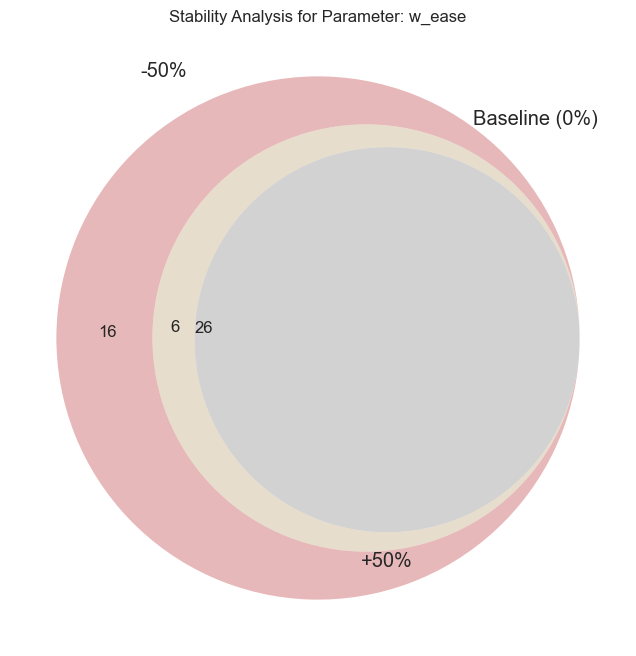

In [79]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
param='w_ease'
subset=stability_df[stability_df['Parameter'] == param]
# Example Venn diagram for three variations
set_minus_50 = set(subset[subset['Variation (%)'] == -50]['Selected Indicators'].iloc[0])
set_0 = set(subset[subset['Variation (%)'] == 0]['Selected Indicators'].iloc[0])
set_plus_50 = set(subset[subset['Variation (%)'] == 50]['Selected Indicators'].iloc[0])

plt.figure(figsize=(10,8))
venn3([set_minus_50, set_0, set_plus_50],
      set_labels=('-50%', 'Baseline (0%)', '+50%'))

plt.title(f'Stability Analysis for Parameter: {param}')
plt.show()

In [75]:
subset

,Parameter,Variation (%),Selected Indicators


In [71]:
subset[subset['Variation (%)'] == -50]

,Parameter,Variation (%),Selected Indicators
9,budget,-50.0,"[Body condition scoring, Calving records (deat..."


In [78]:
stability_df

,Parameter,Variation (%),Selected Indicators
0,w_cover,-50.0,"[Body condition scoring, Calving records (deat..."
1,w_cover,0.0,"[Body condition scoring, Calving records (deat..."
2,w_cover,50.0,"[Abdominal discomfort, Agonistic interactions,..."
3,w_ease,-50.0,"[Abdominal discomfort, Agonistic interactions,..."
4,w_ease,0.0,"[Body condition scoring, Calving records (deat..."
5,w_ease,50.0,"[Body condition scoring, Calving records (deat..."
6,w_impact,-50.0,"[Body condition scoring, Calving records (deat..."
7,w_impact,0.0,"[Body condition scoring, Calving records (deat..."
8,w_impact,50.0,"[Abdominal discomfort, Agonistic interactions,..."
9,budget,-50.0,"[Body condition scoring, Calving records (deat..."
